In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import pickle

In [2]:
images = pd.DataFrame(pd.read_pickle("image_info.pkl"))
images

,image_id,root,file,size
0,1,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n03982430_20160.JPEG,133703
1,2,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n02113712_12803.JPEG,26099
2,3,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n03218198_22336.JPEG,137435
3,4,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n02086646_2475.JPEG,91555
4,5,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n02009229_1098.JPEG,125779
...,...,...,...,...
499994,499995,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n02490219_4499.JPEG,121640
499995,499996,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n02490219_1208.JPEG,102475
499996,499997,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n02490219_1567.JPEG,132565
499997,499998,/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS...,n02490219_7352.JPEG,22382


In [3]:
def get_vector(image_path, bins=32):
    # check whether the file exists
    if not os.path.isfile(image_path):
        raise ValueError(f"Die Datei {image_path} existiert nicht.")
    
    # load image
    image = cv2.imread(image_path)
    
    # checker whether the image has been loaded successfully
    if image is None:
        raise ValueError(f"Das Bild {image_path} konnte nicht geladen werden.")

    # extract rgb information of the image
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    
    vector = np.concatenate([red, green, blue], axis=0).reshape(-1)
    return vector

In [4]:
# store all color vector
color_vectors = {}

# iterate through all images
total_images = len(images)
for index, row in tqdm(images.iterrows(), total=total_images, desc="Processing images"):
    image_path = os.path.join(row['root'], row['file'])
    try:
        # calculate color embedding
        vector = get_vector(image_path)
        color_vectors[row['image_id']] = vector
    except ValueError as e:
        print(e)
        color_vectors[row['image_id']] = None  # Handle images that couldn't be loaded

Processing images:   0%|          | 0/499999 [00:00<?, ?it/s]

In [ ]:
# remove vectors with None values
valid_color_vectors = {key: value for key, value in color_vectors.items() if value is not None}

In [ ]:
# store the color vectors in a pickle file
with open('color_vectors.pkl', 'wb') as f:
    pickle.dump(valid_color_vectors, f)

In [ ]:
color_embeddings = pd.read_pickle("color_vectors.pkl")

In [ ]:
image_ids, vectors = zip(*color_embeddings.items())
embeddings = np.array(vectors)

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from color_embeddings import get_vector

In [ ]:
# path of input image
input_image_path = '/Volumes/T7 Shield 1/Downloads/ILSVRC/Data/CLS-LOC/test/ILSVRC2012_test_00000352.JPEG'

# calculate color embedding for the input image
query_vector = get_vector(input_image_path)

In [ ]:
# calculate similarity scores
scores = cosine_similarity([query_vector], embeddings)[0]

In [ ]:
# Find the closest 10 vectors and their similarity scores
closest_indices = np.argsort(-scores)[1:20]
closest_vectors = scores[closest_indices]

print("Indices of the 10 closest vectors:\n", closest_indices)
print("Similarity/Distance of the 10 closest vectors:\n", scores[closest_indices])

Indices of the 10 closest vectors:
 [32561 70936 61653 41599 19221 44506 96340 53452 49044 50722 70313 52696
 68029 95139 60412 88629 87924 63913 14155]
Similarity/Distance of the 10 closest vectors:
 [0.97843623 0.95695424 0.95623237 0.9547199  0.9540291  0.9505299
 0.9471383  0.9468175  0.94637764 0.94486    0.9436543  0.94228756
 0.9403485  0.9396026  0.93730545 0.93344235 0.9331268  0.9314748
 0.92837703]


In [ ]:
# find image IDs of the 10 most similar images
closest_image_ids = [image_ids[i] for i in closest_indices]
print("IDs der 10 ähnlichsten Bilder:\n", closest_image_ids)

IDs der 10 ähnlichsten Bilder:
 [32562, 70937, 61654, 41600, 19222, 44507, 96341, 53453, 49045, 50723, 70314, 52697, 68030, 95140, 60413, 88630, 87925, 63914, 14156]


In [ ]:
import matplotlib.pyplot as plt

# function to display an image
def show_image(image_path, title):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

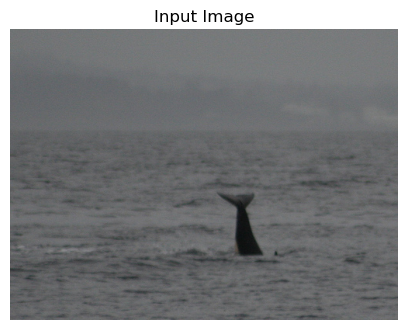

In [ ]:
# display input image
show_image(input_image_path, "Input Image")

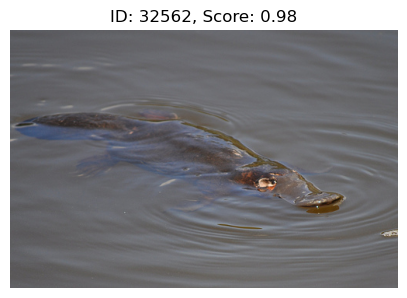

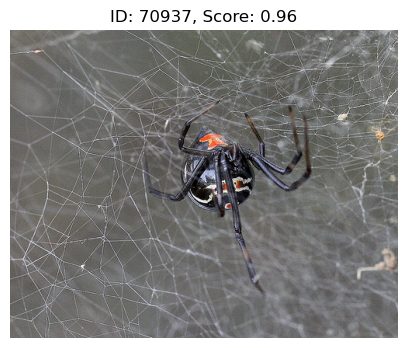

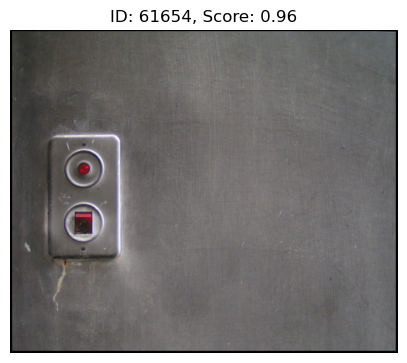

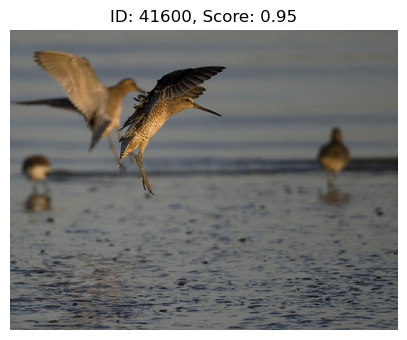

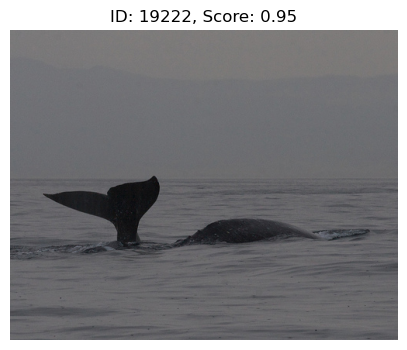

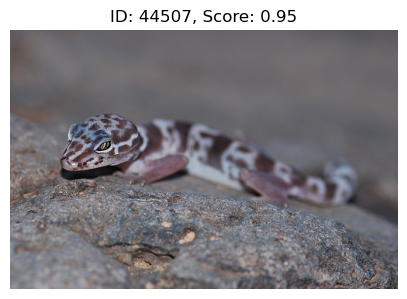

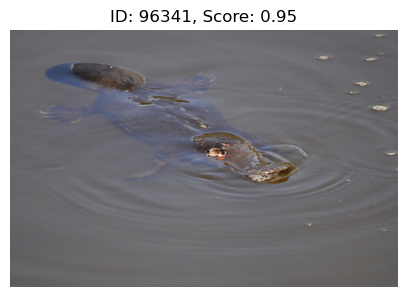

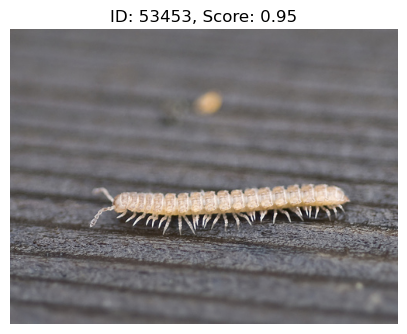

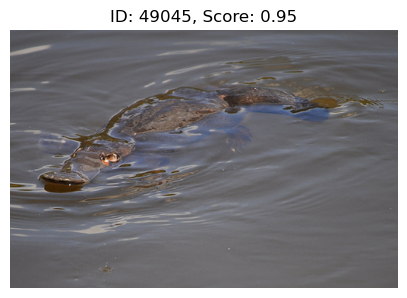

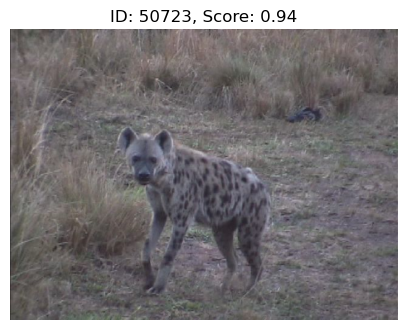

In [ ]:
# Retrieve information of the most similar image from the CSV file
for i in range(10):
    closest_image_id = closest_image_ids[i]
    closest_score = closest_vectors[i]
    closest_image_info = images[images['image_id'] == closest_image_id].iloc[0]

    # get image path and set title
    image_path = os.path.join(closest_image_info['root'], closest_image_info['file'])
    title = f"ID: {closest_image_id}, Score: {closest_score:.2f}"

    # display most similar image
    show_image(image_path, title)